In [1]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
reload(brownian)
reload(time_series)
from time_series import find_files, find_ders, Collection, bin_func

from scipy.signal import detrend
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import numpy as np

# New function definitions

In [2]:
def sort_fnames(fnames, include=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    return fnames_sorted

# Directory structure

In [3]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20211215']

In [4]:
# Select a date
date_der_index = -1
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20211215/bead1']

In [5]:
# Select a bead
bead_der_index = 0
experiment_ders = find_ders(bead_ders[bead_der_index])
experiment_ders

['/data/brownian/20211215/bead1/pulse1']

In [6]:
# Select an experiment
experiment_der_index = 0
fnames = find_files(experiment_ders[experiment_der_index])
fnames

['/data/brownian/20211215/bead1/pulse1/iter_8.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_9.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_5.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_7.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_4.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_10.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_1.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_3.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_6.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_2.tdms']

In [7]:
sort_fnames(fnames, include=[1,3])

['/data/brownian/20211215/bead1/pulse1/iter_1.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_3.tdms']

# PSD calibration

In [8]:
from brownian import abc_guess, get_krhoA, psd_func, logbin_func
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

0 [2.02072677e-05 1.33397145e+03 6.42383973e+05 2.94056893e+02]
1 [2.16525785e-05 1.39342349e+03 6.64473133e+05 2.94056664e+02]
2 [2.23608226e-05 1.41922417e+03 6.63539683e+05 2.94044490e+02]
3 [2.17566595e-05 1.41073046e+03 6.44716350e+05 2.94025260e+02]
4 [2.12807287e-05 1.36959950e+03 6.24349632e+05 2.94038118e+02]
5 [2.19158415e-05 1.41108392e+03 6.38844409e+05 2.94027627e+02]
6 [2.21886035e-05 1.43623804e+03 6.65393030e+05 2.94008778e+02]
7 [2.22422713e-05 1.42818563e+03 6.37651182e+05 2.93995540e+02]
8 [2.16887601e-05 1.40851305e+03 6.41012976e+05 2.93999260e+02]
9 [2.17356674e-05 1.38664128e+03 6.31506468e+05 2.93974596e+02]


Text(0.5, 0, 'Frequency (Hz)')

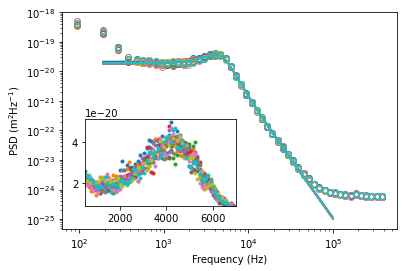

In [9]:
fmin = 5e2
fmax = 4e4
bin_average_Npts = 32


fig, ax = plt.subplots(1,1, figsize=(6,4))
axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)


krhoATs = []
for fnamei, fname in enumerate(sort_fnames(fnames)):
    color = f"C{fnamei}"
    C = Collection(fname)
    T = np.mean(C.Ts) + 273.15
    C.set_collection("X", bin_average=bin_average_Npts)
    C.apply("detrend", inplace=True, mode="constant")
    freq, psd = C.average("PSD", taumax=100e-3)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    krhoA = get_krhoA(*abc, C.R, T)
    k, rho, A = krhoA
    krhoAT = np.r_[krhoA, T]
    krhoATs.append(krhoAT)    
    print(fnamei, krhoAT)
    psd /= A*A
    
    logfreq  = logbin_func(freq, Npts=20)
    logpsd  = logbin_func(psd, Npts=20)
    logmask = np.logical_and(logfreq>fmin, logfreq<fmax)
    ax.loglog(logfreq, logpsd, mec=color, mfc="none", marker="o", ls="none")
    line_mask = np.logical_and(freq>100, freq<1e5)
    ax.loglog(freq[line_mask], psd_func(freq, k, rho, T, C.R)[line_mask], c=color)
    axins.plot(freq, psd, c=color, marker=".", ls="none")
    axins.set_xlim(500, 7000)
    axins.set_ylim(0.9e-20, 5.1e-20)
    
krhoATs = np.array(krhoATs)
ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
ax.set_xlabel(r"Frequency (Hz)")

k : 21.70292007289762 0.5853952677016306 2.6973110795015374
rho : 1399.7610999797562 28.797147185969216 2.0572901466104243
A : 1.550145730861899 0.03255899064186965 2.1003825636294513
T : 20.872722357946856 0.026193345345563154 0.12549079557698703


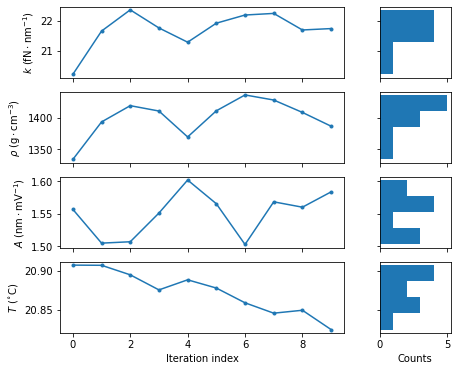

In [10]:
fig, axs = plt.subplots(4,2, figsize=(7, 6), gridspec_kw={"width_ratios":[0.8, 0.2]}, sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \cdot nm^{-1})}$", r"$\rho~{\rm (g \cdot cm^{-3})}$", r"$A~{\rm (nm \cdot mV^{-1})}$", r"$T~{\rm (^{\circ}C)}$"]

for parami, param in enumerate(["k", "rho", "A", "T"]):
    vals = krhoATs[:, parami]
    # units
    if param == "k":
        vals = vals * 1e15 / 1e9
    if param =="A":
        vals = 1/vals * 1e9/1e3
    if param == "T":
        vals = vals -273.15
    # plot data
    axs[parami, 0].plot(vals, marker=".")
    axs[parami, 1].hist(vals, bins=4, orientation="horizontal")
    # labels
    axs[parami, 0].set_ylabel(ylabels[parami])
    axs[3, 0].set_xlabel("Iteration index")
    axs[3, 1].set_xlabel("Counts")
    print(param, ":", np.mean(vals), np.std(vals), 100*np.std(vals)/np.mean(vals))
    


# 100-trial time-domain averages

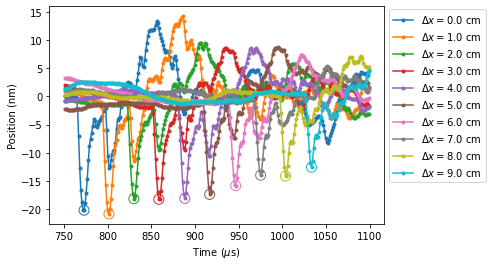

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,4))


Npts = 32
tmin = 750e-6
tmax = 1100e-6
recordi = "average"
#recordi = 0
poses = []
tpeaks = []
Vpeaks = []
for fnamei, fname in enumerate(sort_fnames(fnames)):
    cal = 1 / krhoATs[fnamei, -2]
    color = f"C{fnamei}"
    C = Collection(fname)
    pos = C.pos - 1
    poses.append(pos)
    
    C.set_collection("X", bin_average=Npts)

    if recordi == "average":
        t, x = C.aggrigate()
    else:
        t, x = C.collection[recordi]()

    mask = np.logical_and(t>tmin, t<tmax)
    tm, xm = t[mask], x[mask]
    xm -= np.mean(xm)
    peakdex = np.argmin(xm)
    tpeak = tm[peakdex]
    Vpeak = xm[peakdex]
    tpeaks.append(tpeak)
    Vpeaks.append(Vpeak)
    ax.plot(1e6*tm, 1e9*cal*xm, marker=".", color=color, label="$\Delta x = $%s cm"%pos)
    ax.scatter([1e6*tpeak], [1e9*cal*Vpeak], marker="o", ec=color, fc="none", s=100)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.01))

delta_ts = np.array(tpeaks)-tpeaks[0]
poses = np.array(poses)

ax.set_ylabel("Position (nm)")
ax.set_xlabel(r"Time ($\mu$s)");

Text(0, 0.5, 'velocity ${\\rm (mm s^{-1})}$')

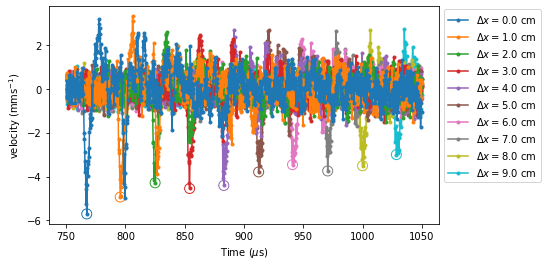

In [98]:
fig, ax = plt.subplots(1,1, figsize=(7,4))


Npts = 16
tmin = 750e-6
tmax = 1050e-6
recordi = "average"
#recordi = 0
poses = []
tpeaks = []
Vpeaks = []
for fnamei, fname in enumerate(sort_fnames(fnames)):
    cal = 1 / krhoATs[fnamei, -2]
    color = f"C{fnamei}"
    C = Collection(fname)
    pos = C.pos - 1
    poses.append(pos)
    
    C.set_collection("VX", bin_average=Npts/2)

    if recordi == "average":
        t, x = C.aggrigate()
    else:
        t, x = C.collection[recordi]()

    mask = np.logical_and(t>tmin, t<tmax)
    tm, xm = t[mask], x[mask]
    xm -= np.mean(xm)
    peakdex = np.argmin(xm)
    tpeak = tm[peakdex]
    Vpeak = xm[peakdex]
    tpeaks.append(tpeak)
    Vpeaks.append(Vpeak)
    ax.plot(1e6*tm, 1e3*cal*xm, marker=".", color=color, label="$\Delta x = $%s cm"%pos, zorder=len(fnames)-fnamei)
    ax.scatter([1e6*tpeak], [1e3*cal*Vpeak], marker="o", ec=color, fc="none", s=100)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.01))

delta_ts = np.array(tpeaks)-tpeaks[0]
poses = np.array(poses)

#ax.set_ylabel("Velocity ${\rm (mm \cdot s^{-1})}$")
ax.set_xlabel(r"Time ($\mu$s)")
ax.set_ylabel(r"velocity ${\rm (mm s^{-1})}$")

342.6350901655324


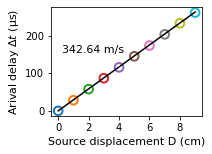

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2.))
def slope(x, m):
    return m*x

def slope_quad(x, a, b):
    return a*x + b*x*x


popt, pcov = curve_fit(slope, poses, delta_ts, p0=[1/344.0], bounds=[(0,), (np.inf)])
speed = 1 / popt[0]
print(speed*1e-2)
plt.plot(poses, 1e6*poses/speed, c="k")
#popt2, pcov2 = curve_fit(slope_quad, poses, delta_ts, p0=[1/344.0, 0], bounds=[(0,0), (np.inf, np.inf)])
#plt.plot(poses, 1e6*poses*(popt2[0]+poses*popt2[1]), c="k", ls="--")
for fnamei, (pos, dt) in enumerate(zip(poses, delta_ts)):
    color = f"C{fnamei}"
    ax.scatter([pos], [1e6*dt],  marker="o", ec=color, fc="none", s=75, lw=2)
ax.set_ylabel(r"Arival delay $\Delta t$ (${\rm \mu}$s)", size=11)
ax.set_xlabel("Source displacement D (cm)", size=11)
ax.text(0.25, 155, f"{round(speed*1e-2, 2)} m/s", fontsize=11)
plt.savefig("figures/wave_speed.png", bbox_inches="tight", dpi=600)

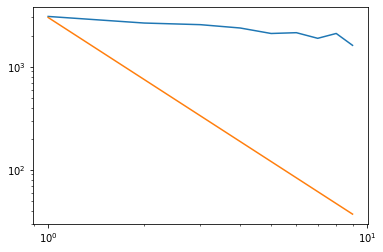

In [27]:
plt.loglog(poses[1:], -np.array(Vpeaks[1:]))
plt.loglog(poses[1:], 3000/poses[1:]**2)

# Single Shot time-domain

In [100]:
fnamei = 0
fname = sort_fnames(fnames)[fnamei]
cal = 1 / krhoATs[fnamei, -2]

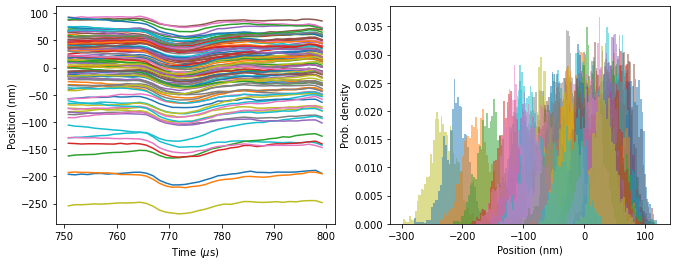

In [16]:
fig, axs = plt.subplots(1,2, figsize=(11, 4))
tmin, tmax = 750e-6, 800e-6
xmin, xmax = -300e-9, 150e-9

C = Collection(fname)
C.set_collection("X", bin_average=Npts)
for D in C.collection:
    mask = np.logical_and(D.t>tmin, D.t<tmax)
    axs[0].plot(D.t[mask]*1e6, D.x[mask]*cal*1e9)
    hist_mask = np.logical_and(D.x*cal>xmin, D.x*cal<xmax)
    axs[1].hist(D.x[hist_mask]*cal*1e9, bins=50, alpha=0.5, density=True)
    

axs[0].set_ylabel("Position (nm)")
axs[0].set_xlabel(r"Time ($\mu$s)")
axs[1].set_xlabel("Position (nm)")
axs[1].set_ylabel("Prob. density");

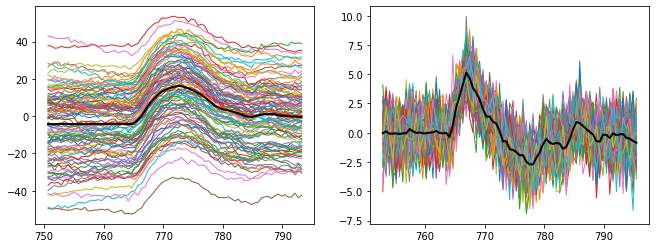

In [101]:
fig, axs = plt.subplots(1,2, figsize=(11, 4))

tmin, tmax = 750e-6, 793e-6

C = Collection(fname)
E = 0
for chi, ch in enumerate(["X", "VX"]):
    C.set_collection(ch, bin_average=Npts)
    if ch == "X":
        unit = -1e9
    if ch == "VX":
        unit = -1e3
        C.apply("bin_average", Npts=2, inplace=True)
    
    C.apply("detrend", mode="constant", inplace=True)
    mask = np.logical_and(C.t>tmin, C.t<tmax)
    for Di, D in enumerate(C.collection):
        color = f"C{Di}"
        t, x = D.t[mask], D.x[mask]* cal
        axs[chi].plot(t*1e6, x*unit, color=color, lw=1)
        
    tbar, xbar = C.aggrigate()
    tbar, xbar = tbar[mask], xbar[mask]* cal
    axs[chi].plot(tbar*1e6, xbar*unit, color="k", lw=2)


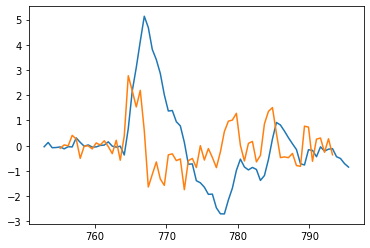

In [102]:
from time_series import firstdiff
t, a = firstdiff((tbar, xbar))
plt.plot(tbar*1e6, -xbar*1e3)
plt.plot(t*1e6, -a*1e-3)

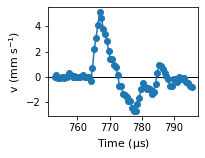

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2.))
ax.plot(tbar*1e6, -xbar*1e3, marker="o")
ax.axhline(0, c="k", lw=1, zorder=0)
ax.set_xlabel(r"Time (${\rm \mu}$s)", size=11)
ax.set_ylabel(r"v ${\rm (mm ~ s^{-1})}$", size=11)
plt.savefig("figures/100-avg_velocity-pulse.png", bbox_inches="tight", dpi=600)

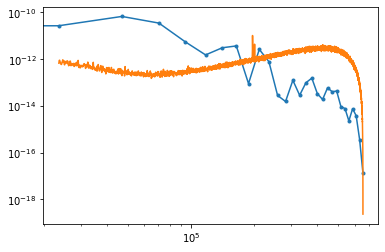

In [90]:
freq_pulse, psd_pulse, N = PSD(xbar, 1/C.r)
freq, psd = C.average("PSD")

plt.loglog(freq_pulse, psd_pulse, marker=".")
plt.loglog(freq[freq>freq_pulse[1]], psd[freq>freq_pulse[1]]*cal*cal)

In [153]:
(5/C.r)

2.800000000000003e-06

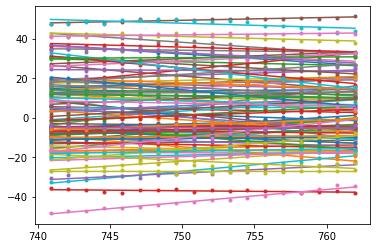

In [32]:
fnamei = 0
tmin, tmax = 740e-6, 763e-6
fname = sort_fnames(fnames)[fnamei]
C = Collection(fname)
cal = 1 / krhoATs[fnamei, -2]
m = 4 * np.pi * krhoATs[fnamei, 1] * C.R**3 / 3
k = krhoATs[fnamei, 0]

C.set_collection("X", bin_average=Npts)
C.apply("detrend", mode="constant", inplace=True)
xvbars = []
res = []
for Di, D in enumerate(C.collection):
    color = f"C{Di}"
    mask = np.logical_and(D.t>tmin, D.t<tmax)
    t, x = D.t[mask], D.x[mask]* cal
    vbar, b  = np.polyfit(t, x, deg=1)
    res.append((x - np.poly1d([vbar, b])(t)))
    xbar = b + vbar*(tmax*tmax-tmin*tmin) / (2*(tmax-tmin))
    xvbars.append([xbar, vbar])
    plt.plot(t*1e6, x*1e9, marker=".", ls="none",  color=color)
    plt.plot(t*1e6, (t*vbar+b)*1e9,  color=color)
    #plt.axhline(xbar*1e9, color=color)
xvbars = np.array(xvbars)
res = np.array([el for r in res for el in r])


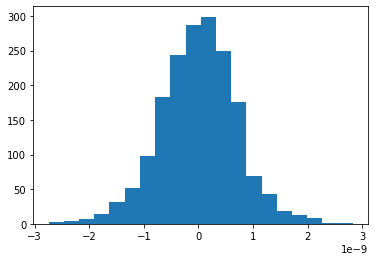

In [33]:
plt.hist(res, bins=20);

In [34]:
E = k * xvbars[:, 0]**2 / 2 + m * xvbars[:, 1]**2 / 2
inds = np.argsort(E)

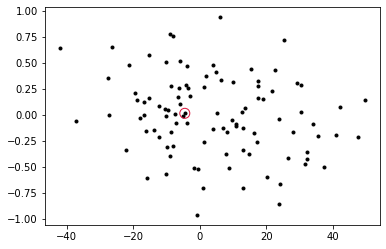

In [35]:
plt.scatter(xvbars[:, 0]*1e9, xvbars[:, 1]*1e3, marker=".", c="k")
plt.scatter([xvbars[inds[0], 0]*1e9], [xvbars[inds[0], 1]*1e3], ec="crimson", fc="none", s=100)